In [1]:
# Autor: Luis Fernando Rascón Calderón
# Título: Clasificación de exoplanetas utilizando modelos de machine learning
# Creación de sesión de Spark para manipulación de base de datos
import os
import sys

os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-11.0.26.4-hotspot"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ClasExo") \
    .master("local[*]") \
    .getOrCreate()

print("Spark Version:", spark.version)


Spark Version: 3.5.5


In [2]:
file_path1 = r"C:\File_path1" # Dirección de archivo que contiene los datos de los parámetros de cada exoplaneta descargado del NASA Exoplanet Archive
file_path2 = r"C:\File_path2" # Dirección de archivo con el nombre y clasificación de los expoplanetas. Se obtiene del webscrapping de la página de NASA Exoplanet Catalog



datos_planetas = spark.read.csv(file_path1, header=True, inferSchema=True, sep=";") # Cambiar delimitador dependiendo del formato del CSV
datos_planetas.show(5)


planetas_names = spark.read.csv(file_path2, header=True, inferSchema=True, sep=",") # Cambiar delimitador dependiendo del formato del CSV
planetas_names.show()

+----------+---------------+---------------+---------+----------+-------+---------+-------+-----------+-----------+------+-------+------+
|   pl_name|discoverymethod|pl_controv_flag|pl_orbper|pl_orbsmax|pl_radj|pl_bmassj|pl_dens|pl_orbeccen|st_spectype|st_rad|st_mass|st_met|
+----------+---------------+---------------+---------+----------+-------+---------+-------+-----------+-----------+------+-------+------+
|  11 Com b|Radial Velocity|              0|   323.21|     1.178|   1.09|   15.464|   14.9|      0.238|     G8 III| 13.76|   2.09| -0.26|
|  11 UMi b|Radial Velocity|              0|516.21997|      1.53|   1.09|    14.74|   13.8|       0.08|     K4 III| 29.79|   2.78| -0.02|
|  14 And b|Radial Velocity|              0|   186.76|     0.775|   1.16|    3.559|   2.76|        0.0|     K0 III| 11.55|   1.78| -0.21|
|  14 Her b|Radial Velocity|              0|1765.0389|     2.774|   1.12|    8.053|   7.03|      0.373|       K0 V|  0.93|   0.91| 0.405|
|16 Cyg B b|Radial Velocity|      

In [3]:
# Union de los dos archivos usando como referencia el nombre de los planetas. Se puede sustituir 'left' por 'inner' 
join_final = datos_planetas.join(planetas_names, datos_planetas["pl_name"] == planetas_names['Nombre del Exoplaneta'], 'inner').select(planetas_names['Nombre del Exoplaneta'], datos_planetas['*'], planetas_names['type'])

In [4]:
join_final.select('Nombre del Exoplaneta', 'pl_name').show(10)

+---------------------+--------------------+
|Nombre del Exoplaneta|             pl_name|
+---------------------+--------------------+
| 1RXS J160929.1-21...|1RXS J160929.1-21...|
|             2M0437 b|            2M0437 b|
| 2MASS J01033563-5...|2MASS J01033563-5...|
| 2MASS J01225093-2...|2MASS J01225093-2...|
| 2MASS J02192210-3...|2MASS J02192210-3...|
|   2MASS J0249-0557 c|  2MASS J0249-0557 c|
| 2MASS J03590986+2...|2MASS J03590986+2...|
| 2MASS J04414489+2...|2MASS J04414489+2...|
| 2MASS J11011926-7...|2MASS J11011926-7...|
| 2MASS J11550485-7...|2MASS J11550485-7...|
+---------------------+--------------------+
only showing top 10 rows



In [5]:
cleaned_joined_final = join_final.filter(join_final['Nombre del Exoplaneta'].isNotNull()) # Limpieza de todas las columnas que tengan nulls en la columna 'Nombre del Exoplaneta'. 

In [6]:
# Guardando el archivo 
pandas_df = cleaned_joined_final.toPandas()
output_file = r"C:Output_filepath" # Dirección donde se desea guardar el archivo
pandas_df.to_csv(output_file, index=False)

print("CSV guardado en: ", output_file)


CSV guardado en:  C:\Tesis\cleaned_output.csv


In [7]:
cleaned_joined_final = cleaned_joined_final.filter(cleaned_joined_final['pl_radj'].isNotNull()).filter(cleaned_joined_final['pl_bmassj'].isNotNull()) # Eliminando nulls en las columnas 'pl_radj' y 'pl_bmassj'

In [8]:
data_for_ml = cleaned_joined_final.drop('Nombre del Exoplaneta', 'pl_controv_flag') # Eliminando columnas que no serán útiles

In [9]:
data_for_ml = data_for_ml.toPandas() # Convirtiendo el data frame de Spark a uno de Panda para poder utilizar los modelos de sklearn

['pl_name',
 'discoverymethod',
 'pl_orbper',
 'pl_radj',
 'pl_bmassj',
 'pl_orbeccen',
 'st_spectype',
 'st_rad',
 'st_mass',
 'st_met',
 'type']

# INICIO DE USO DE MODELOS DE MACHINE LEARNING

## Modelo XGBoost

In [10]:
#Una vez comprobado el funcionamiento del primer modelo, se hace un procedimiento de grid cambiando los valores de hiperparámetros del modelo. 
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Creando una copia de los datos
df = data_for_ml.copy()

# Manejo de NULLs para variables categóricas
categorical_cols = ["discoverymethod", "st_spectype"]
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

# Encoding específico para la clasificación de exoplaneta
type_map = {
    "Gas_giant": 0,
    "Neptune-Like": 1,
    "Super_earth": 2,
    "Terrestrial": 3
}
df["type"] = df["type"].map(type_map)

# Encoding para las demás variables categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df = df.dropna()

# Definición de features y objetivo (target)
X = df.drop(columns=["pl_name", 'pl_dens', 'pl_orbsmax',"type"])
y = df["type"]

# Realización del split train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Valores a probar de los hiperparámetros
param_grid = {
    "max_depth": [4, 6, 8, 10, 12],
    "n_estimators": [10, 15, 20, 50, 100],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.2, 0.6, 0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(
    xgb_clf,
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=2
)
grid_search.fit(X_train, y_train)

print("Mejores parametros:", grid_search.best_params_)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=10, subsample=0.6; total time=   0.0s
[CV] E

              precision    recall  f1-score   support

   Gas_giant       1.00      0.98      0.99       268
Neptune-Like       0.96      0.98      0.97       313
 Super_earth       0.98      0.98      0.98       285
 Terrestrial       0.97      0.97      0.97        34

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



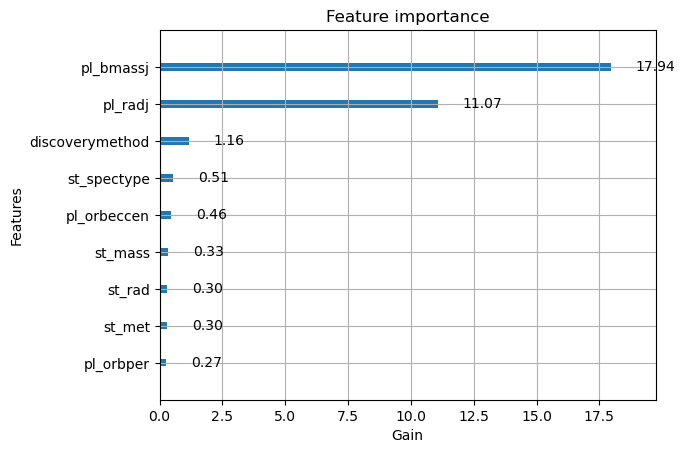

In [11]:
# Probando con los parámetros sugeridos por el grid search
# Creando una copia de los datos
df = data_for_ml.copy()

# Manejo de NULLs para variables categóricas
categorical_cols = ["discoverymethod", "st_spectype"]
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

# Encoding específico para la clasificación de exoplaneta
type_map = {
    "Gas_giant": 0,
    "Neptune-Like": 1,
    "Super_earth": 2,
    "Terrestrial": 3
}
df["type"] = df["type"].map(type_map)

# Encoding para las demás variables categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df = df.dropna()
# Definición de features y objetivo (target)
X = df.drop(columns=["pl_name", "pl_dens", 'pl_orbsmax',"type"])
y = df["type"]

# Realización del split train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamiento de modelo
model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 8, n_estimators = 100, subsample = 1.0,  use_label_encoder=False, eval_metric='mlogloss', missing=np.nan)
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred_xgb = model.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=type_map.keys()))

# Gráfico de importancia de las features
xgb.plot_importance(model, xlabel= 'Gain',importance_type= 'gain', values_format= '{v:.2f}',max_num_features=10)
plt.show()



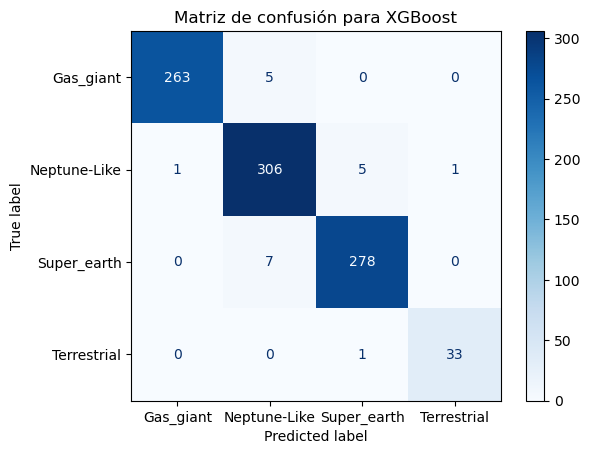

In [14]:
# Evaluación con matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Creación de la matriz y gráfico
cm = confusion_matrix(y_test, y_pred_xgb)

labels = list(type_map.keys())  # ['Gas_giant', 'Neptune-Like', 'Super_earth', 'Terrestrial']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')  

plt.title("Matriz de confusión para XGBoost")
plt.show()


In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Configuración para validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Colocar los mismos hiperparámetros sugeridos por el gridsearch
model = xgb.XGBClassifier(
    learning_rate=0.1, 
    max_depth=8, 
    n_estimators=100, 
    subsample=1.0,
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    missing=np.nan
)

# Enfoque en f1-score
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)

print(f"\nResultados del f1-score en las iteraciones: {cv_scores}")
print(f"Promedio F1 Macro: {cv_scores.mean():.4f}, std dev: {cv_scores.std():.4f}")



Resultados del f1-score en las iteraciones: [0.98479741 0.98655576 0.96500754 0.97977426 0.97988382 0.98493413
 0.97343926 0.97804236 0.99326919 0.99663687]
Promedio F1 Macro: 0.9822, std dev: 0.0087


## Árbol de Decisiones

In [16]:

from sklearn.tree import DecisionTreeClassifier, plot_tree

df = data_for_ml.copy()

# Manejo de NULLs para variables categóricas
categorical_cols = ["discoverymethod", "st_spectype"]
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

# Encoding específico para la clasificación de exoplaneta
type_map = {
    "Gas_giant": 0,
    "Neptune-Like": 1,
    "Super_earth": 2,
    "Terrestrial": 3
}
df["type"] = df["type"].map(type_map)

# Encoding para las demás variables categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df = df.dropna()

# Definición de features y objetivo (target)
X = df.drop(columns=["pl_name", 'pl_orbsmax',"pl_dens", "type"])
y = df["type"]

# Realización del split train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Search Grid para buscar los mejores parámetros para el Árbol de Decisiones
param_grid = {
    'criterion' : ['entropy'],   
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 5,10, 12],
    'min_samples_leaf': [1, 2, 4, 6]         
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro', 
    verbose=2
)

grid_search.fit(X_train, y_train)


print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy

Árbol de Decisiones Classifier Report:
              precision    recall  f1-score   support

   Gas_giant       1.00      1.00      1.00       268
Neptune-Like       0.96      0.98      0.97       313
 Super_earth       0.98      0.96      0.97       285
 Terrestrial       1.00      1.00      1.00        34

    accuracy                           0.98       900
   macro avg       0.99      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



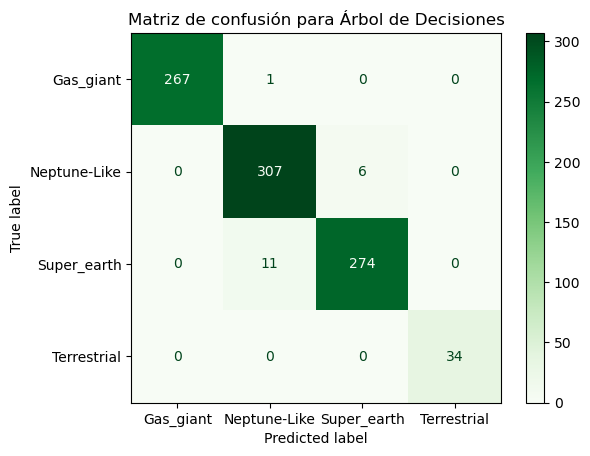

Feature Importances (Árbol de Decisiones):
           Feature  Importance
3        pl_bmassj    0.616850
2          pl_radj    0.360442
4      pl_orbeccen    0.009008
1        pl_orbper    0.005613
8           st_met    0.003203
6           st_rad    0.001651
0  discoverymethod    0.001371
5      st_spectype    0.001199
7          st_mass    0.000662


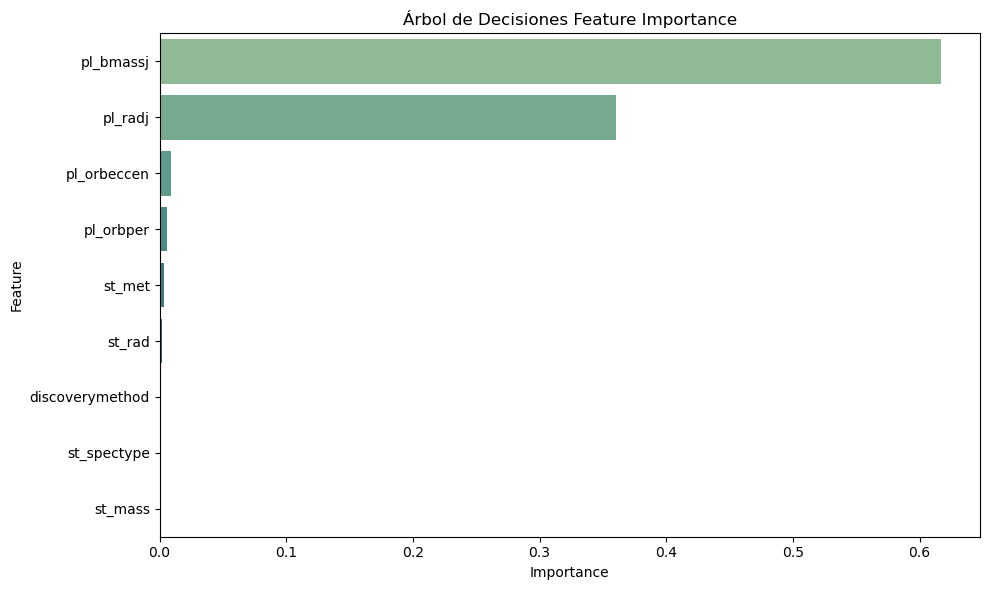

In [17]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import plot_tree



# Definición del modelo usando los parámetros propuestos por el Grid Search
dt_model = DecisionTreeClassifier(
    criterion='entropy',     
    max_depth= 10,
    min_samples_leaf= 2, 
    min_samples_split=12,       
    random_state=42
)

# Entrenamiento del modelo
dt_model.fit(X_train, y_train)

# Realización de predicciones
y_pred_dt = dt_model.predict(X_test)

# Evaluación del modelo
print("Árbol de Decisiones Classifier Report:")
print(classification_report(y_test, y_pred_dt, target_names=type_map.keys()))

# Matriz de confusión
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=type_map.keys())
disp.plot(cmap='Greens', values_format='d')
plt.title("Matriz de confusión para Árbol de Decisiones")
plt.show()

# Gráfico para determinar las features más importantes
importances = dt_model.feature_importances_

feat_importance_df = pd.DataFrame({
    'Feature': X.columns.tolist(),  
    'Importance': importances
})

feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)
feat_importance_df = feat_importance_df[feat_importance_df['Importance'] > 0]

print("Feature Importances (Árbol de Decisiones):")
print(feat_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10), palette='crest')
plt.title("Árbol de Decisiones Feature Importance")
plt.tight_layout()
plt.show()

# Gráfica del Árbol de Decisiones
plt.figure(figsize=(40, 20), dpi=300)  
plot_tree(
    dt_model,
    feature_names=X.columns.tolist(),
    class_names=list(type_map.keys()),
    filled=False,
    max_depth=10,
    rounded=True,
    precision=2
)
plt.title("Árbol de Decisiones - Profundidad 10", fontsize=18)
plt.tight_layout()
plt.show()

In [18]:
# Configuración para validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Colocar los parámetros propuestos por el Grid Search
dt_model = DecisionTreeClassifier(
    criterion='entropy',     
    max_depth=10,
    min_samples_leaf=2, 
    min_samples_split=12,       
    random_state=42
)

cv_scores_dt = cross_val_score(dt_model, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)

print(f"\nResultados de f1-score macro de las iteraciones: {cv_scores_dt}")
print(f"Promedio F1 Macro: {cv_scores_dt.mean():.4f}, std dev: {cv_scores_dt.std():.4f}")


Resultados de f1-score macro de las iteraciones: [0.98483988 0.97511685 0.97991138 0.9797638  0.97486864 0.97991727
 0.98819887 0.97972033 0.98654749 0.99159474]
Promedio F1 Macro: 0.9820, std dev: 0.0053


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

df = data_for_ml.copy()

# Quitando toda la data categórica para que pueda funcionar el modelo
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('type')       
categorical_cols.remove('pl_name')    
encoded_df = df.drop(columns=categorical_cols)

# Eliminando valores nulos que puedan afectar el comportamiento del modelo
cleaned_data = encoded_df.dropna()

# Split de features y target
X = cleaned_data.drop(columns=['pl_name', 'pl_dens', 'pl_orbsmax','type'])
y = cleaned_data['type']

# Split de datos de entrenamiento 80% y prueba 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Parámetros para el grid search
param_grid = {
    'criterion' : ['entropy'],
    'n_estimators': [10, 15, 20, 50, 100],     
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 5,10, 12],
    'min_samples_leaf': [1, 2, 4, 6]          
}

rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',      
    verbose=2,
    n_jobs=-1                
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)





Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 20}


Random Forest Classifier Report:
              precision    recall  f1-score   support

   Gas_giant       1.00      1.00      1.00       268
Neptune-Like       0.96      0.98      0.97       313
 Super_earth       0.98      0.95      0.96       285
 Terrestrial       0.97      1.00      0.99        34

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



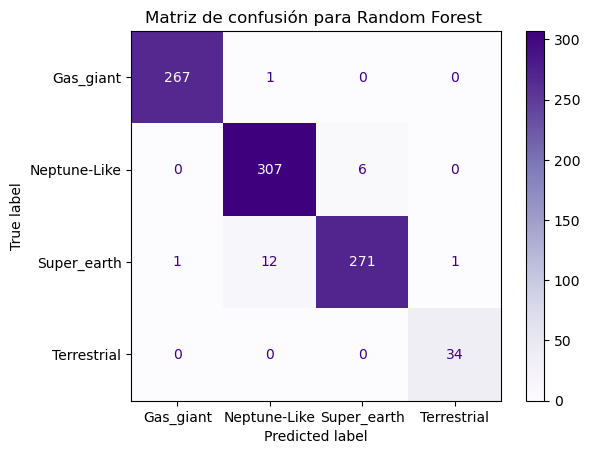

Random Forest Feature Importances:
       Feature  Importance
1      pl_radj    0.465705
2    pl_bmassj    0.434416
0    pl_orbper    0.043898
3  pl_orbeccen    0.019811
4       st_rad    0.013024
5      st_mass    0.011707
6       st_met    0.011439


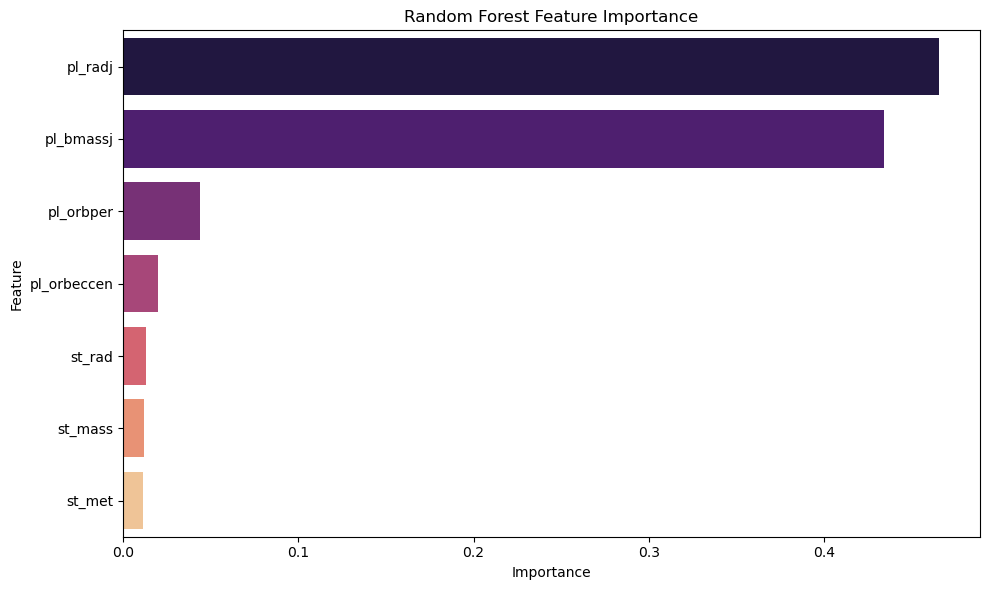

In [20]:
# Setup de parametros y entrenamiento del modelo usando los parámetros del Grid Search
rf_model = RandomForestClassifier(
    criterion='entropy',
    n_estimators=20,
    max_depth=12,
    min_samples_split=12,
    min_samples_leaf=1,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Realización de predicciones
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf, target_names=y.unique()))


# Creando matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=y.unique())
disp_rf.plot(cmap='Purples', values_format='d')
plt.title("Matriz de confusión para Random Forest ")
plt.show()

# Determinación de las features más importantes
importances = rf_model.feature_importances_
feat_importance_rf = pd.DataFrame({
    'Feature': X.columns.tolist(),
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(feat_importance_rf)

# 10 features más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_rf.head(10), palette='magma')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()



In [21]:
# Configuración para validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Utilizar los parámetros propuestos por el Grid Search
rf_model = RandomForestClassifier(
    criterion= 'entropy', 
    n_estimators=20,
    max_depth=12,
    min_samples_split=12,
    min_samples_leaf=1,
    random_state=42
)

cv_scores_rf = cross_val_score(rf_model, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)

print(f"\nResultados de f1-score de las iteraciones: {cv_scores_rf}")
print(f"Promedio F1 Macro: {cv_scores_rf.mean():.4f}, std dev: {cv_scores_rf.std():.4f}")



Resultados de f1-score de las iteraciones: [0.97972876 0.97172219 0.97480515 0.95648001 0.97638068 0.97991138
 0.98147523 0.98140275 0.98821669 0.99326401]
Promedio F1 Macro: 0.9783, std dev: 0.0094


## K-Nearest Neighbors

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

df = data_for_ml.copy()

categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('type')       
categorical_cols.remove('pl_name')    

df_numeric = df.drop(columns=categorical_cols)

df_cleaned = df_numeric.dropna()


X = df_cleaned.drop(columns=['pl_name', 'pl_dens', 'pl_orbsmax','type'])
y = df_cleaned['type']

# Normalización de datos (exclusivo para el funcionamiento del modelo KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Configuración de Grid Search
param_grid = {
    'n_neighbors': list(range(3, 67, 2)),   
    'weights': ['uniform', 'distance'],    
    'metric': ['euclidean', 'manhattan']   
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',  
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros")
print(grid_search.best_params_)


Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Mejores hiperparámetros
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


KNN Classifier Report:
              precision    recall  f1-score   support

   Gas_giant       0.99      0.94      0.97       268
Neptune-Like       0.85      0.85      0.85       313
 Super_earth       0.80      0.87      0.83       285
 Terrestrial       0.82      0.53      0.64        34

    accuracy                           0.87       900
   macro avg       0.86      0.80      0.82       900
weighted avg       0.87      0.87      0.87       900



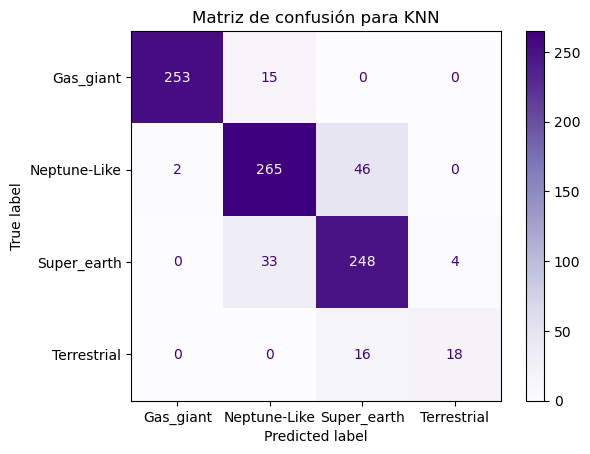

In [24]:
# Entrenamiento con datos propuestos por Grid Search
df = data_for_ml.copy()

categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('type')
categorical_cols.remove('pl_name')

df_numeric = df.drop(columns=categorical_cols)
df_cleaned = df_numeric.dropna()


X = df_cleaned.drop(columns=['pl_name', 'pl_dens', 'pl_orbsmax','type'])
y = df_cleaned['type']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


knn_model = KNeighborsClassifier(
    n_neighbors=3,       
    weights='distance',   
    metric='manhattan'    
)


knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)


print("KNN Classifier Report:")
print(classification_report(y_test, y_pred, target_names=y.unique()))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())
disp.plot(cmap='Purples', values_format='d')
plt.title("Matriz de confusión para KNN")
plt.show()



In [25]:
# Configuración de validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Utilizar los parámetros sugeridos por el Grid Search
knn_model = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    metric='manhattan'
)

cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=skf, scoring='f1_macro', n_jobs=-1)

print("Resultados de f1-score de las iteraciones:", cv_scores_knn)
print(f"Promedio F1 Macro: {cv_scores_knn.mean():.4f}, std dev: {cv_scores_knn.std():.4f}")

Resultados de f1-score de las iteraciones: [0.78605269 0.82886432 0.76580364 0.80597706 0.80675594 0.84410629
 0.85938081 0.75341662 0.87705241 0.77243911]
Promedio F1 Macro: 0.8100, std dev: 0.0395
